# Resolução de Redes em python

Giovanna de Freitas Velasco - 1367634
João Pedro Gomes - 13839069

### Exercício A

Importar bibliotecas que serão usadas durante o exercício

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Criar função `GeraMatriz` para gerar a matriz de condutâncias de uma rede hidráulica.

In [2]:
# Gera matriz de condutâncias
# nv: número de vértices
# nc: número de canos
# C: lista de condutâncias do cano
# connec: matriz de connecções
def GeraMatriz(nv, nc, C, conec):
    # Gera matriz de condutâncias, inicialmente nula
    A = np.zeros([nv, nv])

    # iterar sobre índices de cano 
    for i_cano in range(nc):
        # condutancia do i-ésimo cano
        cond_cano = C[i_cano]
        # "nós" nos quais há conexão do cano
        p, q = conec[i_cano]
        # matriz 2x2 de condutâncias locais entre nó p e nó q
        c_local = np.array([
            [cond_cano, -cond_cano], 
            [-cond_cano, cond_cano]
        ])
        # "somar" a matriz c_local na linha p, coluna q da matriz de condutâncias
        A[p, p] += c_local[0,0]
        A[p, q] += c_local[0,1]
        A[q, p] += c_local[1,0]
        A[q, q] += c_local[1,1]
    
    return A

Declarar função `ResolveRedes1`, para resolver redes nas quais um vértice está com pressão no nível da atmosfera e outro recebe uma vazão constante $QB$ utilizando a parte de álgebra linear da biblioteca NumPy

In [16]:
# Função que resolve uma rede tal que :
## um dos vertices nAtm está conectado à atmosfera
## outro nó nB recebe uma vazão QB

def ResolveRedes1(nv, nc, C, conec, nAtm, nB, QB):
    A = GeraMatriz(nv, nc, C, conec)
    
    # cópia da matriz A para a nova matriz NovaA
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    # a vazão no ponto B é igual a Qb
    Soma_cond = np.zeros(nv, dtype = float)
    Soma_cond[nB] = QB

    # a pressão em nAtm é igual a zero
    NovaA[nAtm, :] = 0.0
    NovaA[nAtm, nAtm] = 1.0

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)
    
    return pressure, max_pressure


A função `ResolveRede2`, de forma similar, resolve redes onde um nó tem pressão fixa e canos têm perdas de pressão.

In [37]:
# função que resolve redes tal que:
## há uma pressão fixa Pf a um nó nf
## há um consumo pré-estabelecido nos demais canos

def ResolveRede2(nv, nc, C, conec, nf, Pf):
    A = GeraMatriz(nv, nc, C, conec)

    # cópia da matriz A para a nova matriz A
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    NovaA[nf,:] = 0.0
    NovaA[nf,nf] = 1.0

    # a vazão nos demais canos diminui proporcionalmente ao consumo
    Soma_cond = -0.1 * np.ones(nv, dtype=float)
    Soma_cond[nf] = Pf

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)
    
    return pressure, max_pressure

Definir função que gera automaticamente os parâmetros para uma rede quadrada, com $lin$ linhas e $col$ colunas de nós

In [79]:
#Função que cria uma Rede Hidraulica em grade quadrada
#lin: numero de linhas
#col: numero de colunas
#CH: condutância dos canos horizontais
#CV: condutância dos canos verticais
#retorna número de vértices, número de canos,
#lista de condutâncias, matriz de conecções
#e coordenadas dos vértices
def CriaRedeQuad(lin, col, CH, CV):
    #numero de vertices e arestas
    nv = lin * col
    nc = (lin - 1) * col + (col - 1) * lin # arestas verticais + horizontais
    
    #criação da matriz de coordenadas dos vértices
    cond = np.zeros(shape = (nv,2))
    
    #popular matriz de coordenadas
    for i in range (lin):
        for j in range (col):
            ig = i + j * lin
            cond[ig,0] = i
            cond[ig,1] = j
            
    #matriz de conexões e condutancia
    conec = np.zeros(shape = (nc,2), dtype = int)
    C = np.zeros(nc)
    
    #Popular condutâncias (canos horizontais)
    for j in range(col):
        for i in range(lin - 1):
            k = j*(lin - 1) + i
            conec[k,0] = j*lin + i
            conec[k,1] = j*lin + i+1
            C[k] = CH
            
    #Popular condutâncias (canos verticais)
    for i in range(lin):
        for j in range(col - 1):
            k = (lin - 1)*col + j*lin + i
            conec[k,0] = i + j*lin
            conec[k,1] = i + (j+1)*lin
            C[k] = CV

    return nv, nc, conec, C, cond

Para verificar a pressão em cada aresta da matriz, utilizamos a função PlotaPress. Para exibir as pressões nas Redes do Tipo 1, escolhemos valores para uma rede 8x8 e plotamos o gráfico para dois cenários distintos.

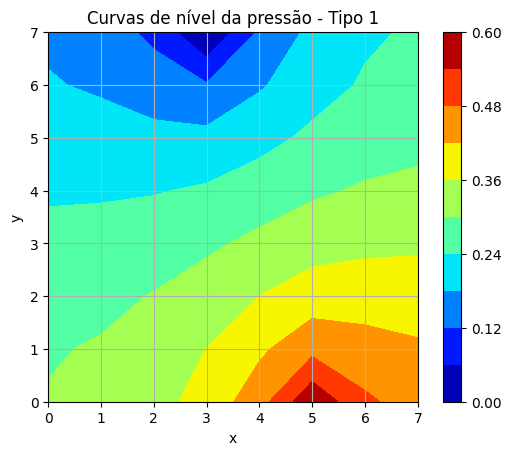

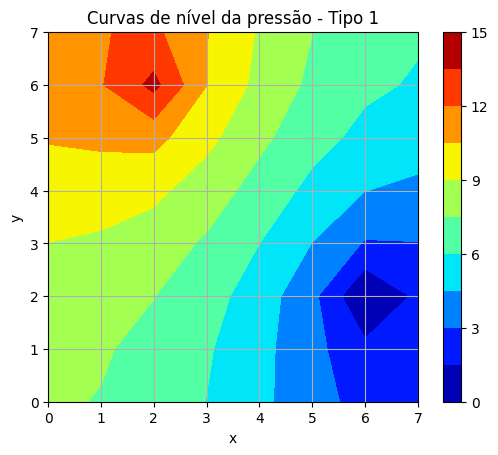

In [81]:
# Dados da rede proposta
lin = 8
col = 8
CH = 3.0
CV = 4.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(lin, col, CH, CV)

# Valores de teste para a Rede
natm = 3
nB = 12
QB = 2.7

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)


def PlotaPress(lin, col , pressure):
    # Criação de uma meshgrid
    x = np.arange(0, lin, 1)
    y = np.arange(0, col, 1)
    X,Y = np.meshgrid(x,y)
    
    # Armazenamento dos valores das pressões
    Z = np.copy(pressure)
    Z.shape = (col ,lin)
    
    # Plotagem das curvas de nível
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title = 'Curvas de nível da pressão - Tipo 1')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, 10, cmap = 'jet')
    cb = plt.colorbar(cp)
    plt.show()


# Valores de teste para a Rede
natm = 59
nB = 5
QB = 1.2

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)

PlotaPress(lin, col, pressure)


# Valores de teste para a Rede
natm = 22
nB = 50
QB = 34.5

pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)

PlotaPress(lin, col, pressure)

Realizamos o mesmo procedimento para uma Rede do Tipo 2.

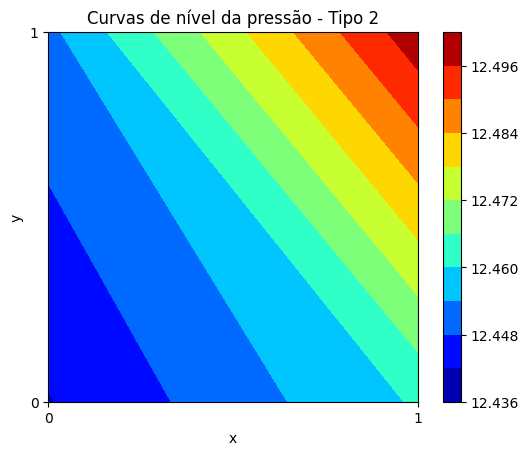

IndexError: index 13 is out of bounds for axis 0 with size 4

In [86]:
# Dados da rede proposta
lin = 2
col = 2
CH = 3.0
CV = 4.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(lin, col, CH, CV)

# Valores de teste para a Rede
nf = 3
Pf = 12.5

pressure, max_pressure = ResolveRede2(nv, nc, C, conec, nf, Pf)

def PlotaPress(lin, col , pressure):
    # Criação de uma meshgrid
    x = np.arange(0, lin, 1)
    y = np.arange(0, col, 1)
    X,Y = np.meshgrid(x,y)
    
    # Armazenamento dos valores das pressões
    Z = np.copy(pressure)
    Z.shape = (col ,lin)
    
    # Plotagem das curvas de nível
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title = 'Curvas de nível da pressão - Tipo 2')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, 10, cmap = 'jet')
    cb = plt.colorbar(cp)
    plt.show()

PlotaPress(lin, col, pressure)

# Valores de teste para a Rede
nf = 13
Pf = 0.25

pressure, max_pressure = ResolveRede2(nv, nc, C, conec, nf, Pf)

PlotaPress(lin, col, pressure)

## Exercício B

In [96]:

def RetornaVazão(conec, C):
    K = np.zeros(shape = (nv,nc))

    print(C)
    print(conec)

    for i in range (nv):
        for j in range(nc):
            if(i == j):
                K[i,j] = C[i]

    print(K)

    D = np.zeros(shape = (nc,nv))
    for k in range (nc):
        p = conec[k,0]
        q = conec[k,1]
        for j in range(nv):
            if(j == p):
                D[k,j] = 1
            if(j == q):
                D[k,j] = -1
    print(D)

    Co = K @ D
    Q = Co @ pressure
    return Q

vaz = RetornaVazão

